In [1]:
###
#  FUTON Model MDP + Q-Learning Creation Script
#  A Research Project conducted by Noah Dunn 
###

# Import the standard tools for working with Pandas dataframe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shelve
# Import the MDP toolbox that contains a method for conducting Q-Learning
# Tool can be found here: https://github.com/sawcordwell/pymdptoolbox
# Documentation for the tool can be found here 
import mdptoolbox

In [2]:
#  The Data File that will be used to conduct the experiments
patientdata = pd.read_csv("G:/MIMIC-ALL/MIMIC-PATIENTS/patient_data_modified.csv")

In [3]:
### 
#  An MDP, or Markov Decision Process is used to model relationships between various states and actions.
#  A state can be thought of in medical solution as a patient's diagnosis based on current vitals and state of being. 
#  An action can be thought of as a change in current diagnosis based on one of those vitals.
#  The inspirations for the bulk of this code came from Komorowksi's AI Clinician which can be found 
#  here: https://github.com/matthieukomorowski/AI_Clinician/blob/master/AIClinician_core_160219.m
###

###
# Begin by establishing some global variables for use in the MDP creation
###
mdp_count = 500            # The number of repititions we want/count of MDPs we need to create 
clustering_iter = 32       # The number of times clustering will be conducted
cluster_sample = 0.25      # Proportion of the data used for clustering
gamma = 0.99               # How close we desire clusters to be in similarity (Percentage)
transition_threshold = 5   # The cutoff value for the transition matrix
final_policies = 1         # The number of policies we would like to end up with
state_count = 750          # The number of distinct states
action_count = 5           # Number of actions per state (reccommended 2 to 10)
crossval_iter = 10         # Number of crossvalidation runs (Default is 80% Train, 20% Test)

In [4]:
###
# Data structures to hold our interim data
###

# Create the structures and fill them with NaN values
optimal_actions = np.empty((state_count + 2, mdp_count,))  # Not sure the significance of the 2 yet
optimal_actions[:] = np.nan


model_data = np.empty((mdp_count*2, 30,))
model_data[:] = np.nan

bestmodels_data = np.empty((mdp_count, 15))

In [5]:
# Grab list of unique patient ICU stay IDs
icu_ids = patientdata['icustayid'].unique()
# Number of patients to be used for states
id_count = icu_ids.size
print(id_count)

# Create a data structure to representing all patients
patient_idxs = np.empty((id_count, mdp_count,))
patient_idxs[:] = np.nan

21463


In [6]:
# All our columns are broken up into 3 distinct categories:
# 1. Binary values (0 or 1)
# 2. Standard Ranges (Plain old Integers + Decimals)
# 3. Logarthmic Values (columnvalue = log(columnvalue))

colbin = ['gender','mechvent','max_dose_vaso','re_admission', 'qSOFAFlag', 'SOFAFlag']
colnorm = ['age','Weight_kg','GCS','HR','SysBP','MeanBP','DiaBP','RR','Temp_C','FiO2_1',
    'Potassium','Sodium','Chloride','Glucose','Magnesium','Calcium',
    'Hb','WBC_count','Platelets_count','PTT','PT','Arterial_pH','paO2','paCO2',
    'Arterial_BE','HCO3','Arterial_lactate','SOFA','SIRS','Shock_Index','PaO2_FiO2','cumulated_balance', 'qSOFA'];
collog=['SpO2','BUN','Creatinine','SGOT','SGPT','Total_bili','INR','input_total','input_4hourly','output_total','output_4hourly'];

# Create seperate dataframes for each of the columns
colbin_df = patientdata[colbin]
colnorm_df = patientdata[colnorm]
collog_df = patientdata[collog]

# Let's make sure we have what we need
print(colbin_df, "\n", colnorm_df, "\n", collog_df)

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag
0            0         1            0.0             0          1         0
1            0         1            0.0             0          1         1
2            0         1            0.0             0          1         1
3            0         1            0.0             0          1         1
4            0         1            0.0             0          1         1
...        ...       ...            ...           ...        ...       ...
238325       0         0            0.0             0          1         0
238326       0         0            0.0             0          1         0
238327       0         0            0.0             0          1         0
238328       0         0            0.0             0          1         0
238329       0         0            0.0             0          1         0

[238330 rows x 6 columns] 
                 age  Weight_kg        GCS         HR       SysBP     Me

In [7]:
# Rearrange the dataframe in order of binary, normal, and log data from left to right
MIMIC_raw = pd.concat([colbin_df, colnorm_df, collog_df], axis=1)
print(MIMIC_raw) 

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0            0         1            0.0             0          1         0   
1            0         1            0.0             0          1         1   
2            0         1            0.0             0          1         1   
3            0         1            0.0             0          1         1   
4            0         1            0.0             0          1         1   
...        ...       ...            ...           ...        ...       ...   
238325       0         0            0.0             0          1         0   
238326       0         0            0.0             0          1         0   
238327       0         0            0.0             0          1         0   
238328       0         0            0.0             0          1         0   
238329       0         0            0.0             0          1         0   

                age  Weight_kg        GCS         HR  ...    BU

In [8]:
# We want a Z-Score for every item. This a measure of variance to see how far a value is from the mean

# Scipy provides a library to execute this kind of thing
from scipy.stats import zscore
# We need to normalize binaries to -0.5 and 0.5 for later use
MIMIC_zscores = MIMIC_raw

# No need for the zscore algorithm here, -0.5 and 0.5 suffice
MIMIC_zscores[colbin] = MIMIC_zscores[colbin] - 0.5

# Recall these columns are logarithmic, so they needed converted back for proper Z-Scoring (+ 0.1 to avoid log(0))
MIMIC_zscores[collog] = np.log(MIMIC_zscores[collog] + 0.1).apply(zscore)

# Normal column requires no modifications. Z-Scores are calculated as normal
MIMIC_zscores[colnorm] = MIMIC_zscores[colnorm].apply(zscore)
print(MIMIC_zscores)

# We want Re Admission and fluid intake scaled Similarly to the other variables
MIMIC_zscores['re_admission'] = np.log(MIMIC_zscores['re_admission'] + 0.6)
# Apply a scalar to fluid intake
MIMIC_zscores['input_total'] = 2 * MIMIC_zscores['input_total']

        gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5           -0.5          -0.5        0.5      -0.5   
1         -0.5       0.5           -0.5          -0.5        0.5       0.5   
2         -0.5       0.5           -0.5          -0.5        0.5       0.5   
3         -0.5       0.5           -0.5          -0.5        0.5       0.5   
4         -0.5       0.5           -0.5          -0.5        0.5       0.5   
...        ...       ...            ...           ...        ...       ...   
238325    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238326    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238327    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238328    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   
238329    -0.5      -0.5           -0.5          -0.5        0.5      -0.5   

             age  Weight_kg       GCS        HR  ...       BUN 

In [9]:
### The main loop to generate all possible models

num_rows = id_count  # Total Number of Patients to divy data up
testing_flag = 1     # The random number we use to identify a patient used for testing

# TODO: Change this to 1 in MDP_COUNT
#for model in range(1, 2): #mdp_count):
train_ids = []       # A list containing all training ids from the icu_ids list
test_ids =[]         # A list containing all testing ids from the icu_ids list

# We want approximate 20% test, 80% train, so we random numbers 1-5
# 1s Represent data points that will be used to test, 2-5 will be used to train
group_ids = pd.DataFrame([int(np.floor(5 * np.random.random() + 1)) for i in range(1, id_count + 1)])
icu_pair_set = pd.concat([pd.DataFrame(icu_ids), group_ids], axis=1, sort=False)
icu_pair_set.columns = ['id', 'fil_val']
train_ids =  icu_pair_set[icu_pair_set['fil_val'] != testing_flag]
test_ids = icu_pair_set[icu_pair_set['fil_val'] == testing_flag]

# We want to insure that the testing patients + training patients = total patients
if (train_ids['id'].size + test_ids['id'].size) != id_count:
    print("The testing and training set do not add up to the total set")
    exit()

# Percentage for testing should be about 20%, Training about 80%
print("Testing Percentage: " + str((test_ids['id'].size / id_count)))
print("Training Percentage: " + str((train_ids['id'].size / id_count)))

# After grabbing all the IDs, we want to flag all the rows that are train or test
train_flag = patientdata['icustayid'].isin(train_ids['id'])
test_flag = patientdata['icustayid'].isin(test_ids['id'])

import pickle
# Temporarily write train_flag for later use DELETE LATER
with open('sample_train.txt', 'wb') as fp:
    pickle.dump(train_flag, fp)

#Validating that all data is being selected, and that the train and test sets are perfect opposites
if patientdata['icustayid'].size != train_flag.size or not((train_flag.equals(~test_flag))):
    print("Not all rows were grabbed properly, there is something wrong with the split")
    exit()

Testing Percentage: 0.20071751386106323
Training Percentage: 0.7992824861389368


In [10]:
# Seperate the Z-Scores for the training set and the testing set
train_zscores = MIMIC_zscores[train_flag]
test_zscores = MIMIC_zscores[test_flag]

# Validate all data is selected
if(train_zscores.size + test_zscores.size != MIMIC_zscores.size):
    print("The Z-Scores are all evenly distributed")
    exit()

    
# The blocs of relevance in order based on the train and test set
# These will be used to build relevant data frames later down
train_blocs = patientdata[train_flag]['bloc']
test_blocs = patientdata[test_flag]['bloc']

# Doing the same with the patient ids
train_id_list = patientdata[train_flag]['icustayid']
test_id_list = patientdata[test_flag]['icustayid']

# Grabbing the boolean values for the patients who died within 90 days in the training set
train_90d = patientdata[train_flag]['mortality_90d']

In [11]:
# Next, we want to sample the existing training set to only pick cluster_sample percent to use

# We want to flag all the data points in the train_zscores set that will be used to create the MDP

# Note: len(train_zscores.index) is the fastest way to get the number of rows in a dataframe in pandas

# Additional Note: np.floor(np.random.random() + cluster_sample) is a computationally speedy way to get an approximate
# percentage sample from a proportion value (cluster_sample). If cluster sample is 0.25, approximately 25% of the values
# will be flagged as a 1, making it into the sample training set
sample_train_flags = [bool(np.floor(np.random.random() + cluster_sample)) for i in range(len(train_zscores.index))]

# It's good to know how much of the data was selected as sample
print("Proportion of Train Data used for the Sample: " + str(sample_train_flags.count(True)/len(sample_train_flags)))

# The actual set to use
sample_train_set = train_zscores[sample_train_flags]

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('train_zscores.txt', 'wb') as fp:
    pickle.dump(train_zscores, fp)

Proportion of Train Data used for the Sample: 0.24880872950410574


In [29]:
# In order to prepare a proper set of states, we want to use k-means clustering to group various patients into 
# distinct states based on Z-Scores

# K-Means or K-Means++ is a technique used to condense very diverse and sparse data into similar groups called 'clusters'
# The K-means algorithm will create k clusters from N data points. In the case of this research,
# the algorithm divides patients into groups that have similar data (age, blood pressure, etc..) and creates a faux 'point'
# at the center of that particular clustering of data


# Skikit offers a solution to perform K-Means++ clustering
from sklearn.cluster import KMeans
# The KMeans takes three 'settings' arguments
# 1. n_clusters: The number of clusters (later to be used as states), that we desire the algorithm to produce
# this value has been preset to state_count which is 750
# 2. max_iter: How many times each round of k-means clustering will make adjustments, set at 10,000 in my case
# 3. n_init: The number of max_iter batches that will be conducted in a row. The best of these will be chosen
# and saved in the variable clusters_models
clusters_models = KMeans(n_clusters=state_count, max_iter=10000, n_init=clustering_iter).fit(sample_train_set)
print(clusters_models.labels_)
print(clusters_models.cluster_centers_)

# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Save the important data (clusters created as a result of the K-Means operations)
# This process takes quite a while. This will provide a checkpoint to decrease compute time
# until the code is put into dev.
with open('cluster_labels.txt', 'wb') as fp:
    pickle.dump(clusters_models.labels_, fp)
with open('cluster_centers.txt', 'wb') as fp:
    pickle.dump(clusters_models.cluster_centers_, fp)

[661 661 661 ... 723 269  34]
[[ 0.04545455 -0.29545455 -0.48977273 ...  0.48636899  0.6861088
   0.68126619]
 [ 0.1119403  -0.20149254 -0.46002985 ... -0.38319409  0.31383807
   0.22843704]
 [-0.29381443  0.44845361 -0.27469072 ...  0.86794583 -0.06877745
   0.44897034]
 ...
 [-0.5        -0.5        -0.5        ... -0.04622178 -2.31206609
  -1.85290276]
 [-0.01694915  0.12711864 -0.46938983 ...  0.4476072   0.53923866
   0.54182028]
 [-0.11538462 -0.05128205 -0.49611538 ...  0.18548205  0.70236543
   0.29841968]]


In [30]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle

# Read these values back in from being saved to file
cluster_values = []
cluster_labels = [] 
train_zscores = []

with open ('cluster_centers.txt', 'rb') as fp:
    cluster_values = pickle.load(fp)
with open ('cluster_labels.txt', 'rb') as fp:
    cluster_labels = pickle.load(fp)
with open ('train_zscores.txt', 'rb') as fp:
    train_zscores = pickle.load(fp)
    
print(cluster_values, "\n", "Dimensions: ", len(cluster_values)," x ", len(cluster_values[0]), "\n", train_zscores)

[[ 0.04545455 -0.29545455 -0.48977273 ...  0.48636899  0.6861088
   0.68126619]
 [ 0.1119403  -0.20149254 -0.46002985 ... -0.38319409  0.31383807
   0.22843704]
 [-0.29381443  0.44845361 -0.27469072 ...  0.86794583 -0.06877745
   0.44897034]
 ...
 [-0.5        -0.5        -0.5        ... -0.04622178 -2.31206609
  -1.85290276]
 [-0.01694915  0.12711864 -0.46938983 ...  0.4476072   0.53923866
   0.54182028]
 [-0.11538462 -0.05128205 -0.49611538 ...  0.18548205  0.70236543
   0.29841968]] 
 Dimensions:  750  x  50 
         gender  mechvent  max_dose_vaso  re_admission  qSOFAFlag  SOFAFlag  \
0         -0.5       0.5           -0.5     -2.302585        0.5      -0.5   
1         -0.5       0.5           -0.5     -2.302585        0.5       0.5   
2         -0.5       0.5           -0.5     -2.302585        0.5       0.5   
3         -0.5       0.5           -0.5     -2.302585        0.5       0.5   
4         -0.5       0.5           -0.5     -2.302585        0.5       0.5   
...        ..

In [31]:
# We now want to use the clusters to determine their nearest real data point neighbors
# As a visual of this. Suppose we have 4 flags of different colors scattered over a park. The K-Means++ algorithm
# is what planted the flags in the middle of groups of people that are similar. The KNN Search (K nearest neighbor search)
# can be used in MatLab as a simple point finder instead of as a more complicated Supervised Learning algorithm. In Python 
# we can make use of the Vector Quanization (vq) package to assign each point to a centroid
from scipy.cluster.vq import vq
closest_clusters = vq(train_zscores, cluster_values)

# Check to make sure each cluster has a value
print(len(closest_clusters[0]))

# As an aside, closest_clusters[1] contains the distance between each point's values (in this case 50 of them)
# and their closest cluster's values.
# Ex: If a point is [1, 1, 1] and it's closest cluster is the point [3, 3, 3]  closest_clusters[1] would contain the vector
# [abs(3 - 1), abs(3 - 1), abs(3 - 1)] or [2, 2, 2]

# Validate that all the points are in the range 0-749 (since there are only 750 clusters as specified previously)
for i in closest_clusters[0]:
    if(i > 749 or i < 0):
        print("The clusters you are searching for are not configured properly and are out of bounds")
        print("Did you modify the cluster_count variable without changing this error configuration?")
        exit()

190343


In [32]:
### 
#  We want to begin constructing the set of possible actions between states
###

# The number of possible actions is represented as an action_count by action_count matrix
# This is assuming that any action in the list can lead to any other action 
number_actions = action_count * action_count

#  This may prove to be not as useful since this is diagnosis based: extracting information on
#  Fluid input and max dose of vasopressors
iv_fluid = patientdata['input_4hourly']

#  Avoid any fluid that is 0 (That was not administered)
iv_fluid = iv_fluid[iv_fluid > 0]
# Determine minimum and maxium to scale data appropriately
print("Old Lowest IV Fluid Rank: ", min(iv_fluid.rank()))
print("New Highest IV Fluid Rank: ", max(iv_fluid.rank()))
# Now we want to rank these actions in order of their value (lowest to highest)
# We normalize our range from (1.5, 173142.0) to (0, 1)

# Moving the minimum to zero
iv_fluid_ranks = (iv_fluid.rank() - min(iv_fluid.rank()))
# Shifting the max to approximately 1
iv_fluid_ranks = iv_fluid_ranks / max(iv_fluid_ranks)

# Validate that the range is indeed 0 to 1
print("Old Lowest IV Fluid Rank: ", min(iv_fluid_ranks))
print("New Highest IV Fluid Rank: ", max(iv_fluid_ranks))

if round(max(iv_fluid_ranks), 3) != 1 or round(min(iv_fluid_ranks), 3) != 0:
    print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
    print("Current max: ", round(max(iv_fluid_ranks), 3))
    print("Curret min: ", round(min(iv_fluid_ranks), 3))
    exit()

# This is a mathematics trick to seperate all the values into three distinct groups based on their rank.
# Since ranks are determined based on Vasopressor quantity, the four groups represent the amount of iv fluid
# Administered to a patient (Group 1 - Low, Group 2 - Mid-Low, Group 3 - Mid-High, Group 4 - High)
iv_fluid_groups = np.floor((iv_fluid_ranks + 0.2499999999) * 4)

# Validate that groups are all associated with the numbers 1-4
if not(iv_fluid_groups.isin([1,2,3,4]).any()):
    print("Groups chosen fall outside the desired 1-4 window")
    
# If an IV fluid amount is 0, we denote it to be action 1. 
# If an IV fluid falls into non-zero amounts, we use ranks built above (1 - 4) plus one. Making 
# the subset of these actions to be action 2 thru 5.
# In short, the model can choose to give a 'patient' 5 different IV amounts 
num_of_rows = patientdata['input_4hourly'].size
iv_fluid_actions = pd.Series([1 for i in range(0, num_of_rows)])

# If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
for index in iv_fluid_groups.index:
    iv_fluid_actions[index] = iv_fluid_groups[index] + 1

print(iv_fluid_actions)
print(iv_fluid_groups)

Old Lowest IV Fluid Rank:  1.5
New Highest IV Fluid Rank:  173142.0
Old Lowest IV Fluid Rank:  0.0
New Highest IV Fluid Rank:  1.0
0         2
1         3
2         3
3         3
4         2
         ..
238325    1
238326    1
238327    1
238328    1
238329    1
Length: 238330, dtype: int64
0         1.0
1         2.0
2         2.0
3         2.0
4         1.0
         ... 
238319    3.0
238320    4.0
238321    4.0
238322    1.0
238324    2.0
Name: input_4hourly, Length: 173142, dtype: float64


In [33]:
###
# The generate_action_column function takes 4 arguments: 
#
# column_values: A series of column values from a dataframe that we want to turn into action states
# num_groups: How many groups or distinct actions we want to split the data into
# column_name: The name of the column used for print debug statements
# num_rows: The total number of rows in the full column before modifications (This is normally patientdata[column_name].size)
# 
# This function returns column_actions, a series that represents the 'action', or group that each row of data falls under.
#
# An example is found down below, but in words, this function takes a full column of data, groups 
# the values for that data into num_groups distinct actions, and returns a series representing actions based on row
# 
# Ex: Patients' blood pressure might be grouped into 5 categories (Action 1: < 20 mmHg, Action 2: > 20 mmHg && < 60 mmHg... etc)
###

def generate_action_column(column_values, num_groups, column_name, num_rows):
    # Determine minimum and maxium to scale data appropriately
    print("Old Lowest ", column_name, " Rank: ", min(column_values.rank()))
    print("Old Highest " , column_name,  " Rank: ", max(column_values.rank()))
    # Now we want to rank these actions in order of their value (lowest to highest)
    # Normalizing according to lowest and highest rank
    
    # Moving the minimum to zero
    column_ranks = (column_values.rank() - min(column_values.rank()))
    # Shifting the max to approximately 1
    column_ranks = column_ranks / max(column_ranks)

    # Validate that the range is indeed 0 to 1
    print("New Lowest ", column_name, " Rank: ", min(column_ranks))
    print("New Highest ", column_name, " Rank: ", max(column_ranks))

    if round(max(column_ranks), 3) != 1 or round(min(column_ranks), 3) != 0:
        print("The ranks are not normalized correctly, either the max is too high, or the minium is too low")
        print("Current max: ", round(max(column_ranks), 3))
        print("Curret min: ", round(min(column_ranks), 3))
        exit()
    # This is a mathematics trick to seperate all the values into {num_groups} distinct groups based on their rank.
    # Given different columns of interest this can take different forms. For IV fluids, this number is 4.
    column_groups = np.floor(((column_ranks + 1.0/float(num_groups) - 0.000000001) * num_groups))

    # Validate that groups are all associated with desired group split
    if not(iv_fluid_groups.isin([i for i in range(1, num_groups + 1)]).any()):
        print("Groups chosen fall outside the desired 1-4 window")
        exit()
    
    column_actions = pd.Series([1 for i in range(0, num_rows)])

    # If the value was non-zero and grouped in the 1 - 4 groups, we grab its value to save as an action
    for index in column_groups.index:
        column_actions[index] = column_groups[index] + 1

    #print(column_actions)
    #print(column_groups)
    return column_actions
    

In [34]:
# This small sample insures the function performs the same as the test conducted above for IV Fluid
iv_fluid = patientdata['input_4hourly']
iv_fluid = iv_fluid[iv_fluid > 0]

test_column = generate_action_column(iv_fluid, 4, "IV Fluid", patientdata['input_4hourly'].size)

print(test_column.equals(iv_fluid_actions))

Old Lowest  IV Fluid  Rank:  1.5
Old Highest  IV Fluid  Rank:  173142.0
New Lowest  IV Fluid  Rank:  0.0
New Highest  IV Fluid  Rank:  1.0
True


In [35]:
# Now we want the exact same thing but done with given Vasopressor amounts
vasopressor_administered = patientdata['max_dose_vaso']
vasopressor_administered = vasopressor_administered[vasopressor_administered > 0]

vasopressor_actions = generate_action_column(vasopressor_administered, 4, "Max Dose Vasopressor", patientdata['max_dose_vaso'].size)
print(vasopressor_actions.unique())

Old Lowest  Max Dose Vasopressor  Rank:  1.0
Old Highest  Max Dose Vasopressor  Rank:  35503.0
New Lowest  Max Dose Vasopressor  Rank:  0.0
New Highest  Max Dose Vasopressor  Rank:  1.0
[1 5 3 4 2]


In [36]:
###
# This function takes two arguments:
# actions_column: A column of action groups generated by the above function (generate_action_column())
# real_values: The actual values from the dataset corresponding to the same column as actions_column
# and returns a list that contains the real median values for each 'group' actions.
#
# Ex: We apply the function to the action_column "IV_Fluid", which has split the data into 4 different groups of 
# IV_Fluid actions. This function will produce a list containing the median amount of IV_Fluid administered for each of those
# groups (Group 1 -> Adminster 20 mL, Group 2 -> Administer 40 mL, Group 3 -> Administer 60 mL, Group 4 -> Administer 80 mL
###

def median_action_values(actions_column, real_values):
    # Grab all the unique actions for a column and sort them
    all_groups = np.sort(actions_column.unique())
    # Concatanate the group number and real value for each row
    action_set = pd.concat([actions_column, real_values], axis=1, sort=False)
    # Name the columns for accurate querying
    action_set.columns = ['group_id', 'data_val']
    # Grab the median value for each group based on group number using python list comprehension
    median_values = [np.median(action_set[action_set['group_id'] == i]['data_val']) for i in all_groups]
    return median_values


In [37]:
iv_median_actions = median_action_values(iv_fluid_actions, patientdata['input_4hourly'])
vasopressor_median_actions = median_action_values(vasopressor_actions, patientdata['max_dose_vaso'])
print("IV Action Median Values:", str(iv_median_actions), "\nVasopressor Action Median Values: ", vasopressor_median_actions, "\n")

IV Action Median Values: [0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] 
Vasopressor Action Median Values:  [0.0, 0.04, 0.135, 0.27, 0.7625] 



In [38]:
### 
# This function takes one argument
# list_action_columns: This is a Pandas dataframe that contains all the action_columns we desir to be grouped by index
# This can be retrieving using the previously defined 'median action' function 
# 
# and returns two items:
# list_action columns: The 'keys' or integers that represent every permutation of actions
# chosen_action: The key that was chosen based on the action values in each column
### 
def generate_action_matrix(list_action_columns):
    # Grabs the list of columns the user has provided for use
    desired_columns = [column for column in list_action_columns]
    # Drops all group combinations that are duplicates
    list_action_columns_indexes = list_action_columns.drop_duplicates(desired_columns)
    # Sorts all combinations in order
    list_action_columns_indexes = list_action_columns_indexes.sort_values(desired_columns)
    # Create a dictionary based on the values from the dataframe 
    list_action_columns_indexes = list_action_columns_indexes.values.tolist() 
    # Determine which index in the list each row corresponds to 
    # Ex: For an 2-D action permutation list of [1,1] thru [5,5], there are 5 x 5 possibilities
    # {1..5}, {1..5}, so there are 25 possible permutations, the indexes will run 1 - 25
    chosen_action = [list_action_columns_indexes.index(val_pair) for val_pair in list_action_columns.values.tolist()]
    # Return the keys first, and then the true values for the dataset
    return list_action_columns_indexes, chosen_action
    

Text(0.5, 0, 'Index of Action Chosen: 1 through 24')

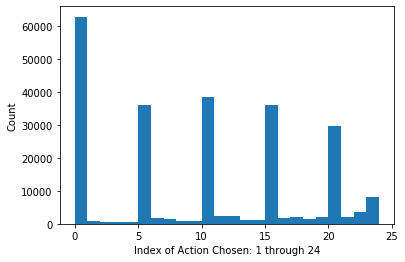

In [39]:
###
# FINISH CONSTRUCTION OF ALL ACTIONS AND THEIR VALUES
###

# Combine the columns that we desire to observe (iv_fluid_actions, vasopressor_actions)
iv_vaso_groups = pd.concat([iv_fluid_actions, vasopressor_actions], axis=1, sort=False)
# Name the columns for proper usage in the function
iv_vaso_groups.columns = ['iv_group', 'vasopressor_group']

action_keys, action_list = generate_action_matrix(iv_vaso_groups)

# Plot the distribution of actions
plt.hist(action_list, density=False, bins=24)  # `density=False` would make counts
plt.ylabel("Count")
plt.xlabel("Index of Action Chosen: 1 through 24")

In [40]:
# Python has object serialization to make write/reads fasters, in the form of pickle
import pickle
train_chosen_actions = []
with open ('sample_train.txt', 'rb') as fp:
    train_chosen_actions = pickle.load(fp)

# Grab a Series representing the action taken by the train data only
train_chosen_actions = pd.Series(action_list)[train_chosen_actions]

# Assign all action choices to their corresponding median values as shown previously
print(iv_median_actions, vasopressor_median_actions)

# Itertools provides an easy way to perform Cartesian product on multiple sets
from itertools import product as cartesian_prod

# This gives us the representative median values for a patient's vitals present in various action groups
# action_keys[i] corresponds to train_action_values[i]
# So, if the patient falls into group [1, 1] or no iv fluid given, no vasopressor administered,
# The corresponding median values for this group will be represented by train_action_values (0.0, 0.0).
# A patient in group [1, 2] (no iv fluid, a little vasopressor) will have a median real value of (0.0, 0.04)
train_action_values = list(cartesian_prod(iv_median_actions, vasopressor_median_actions))

if len(train_action_values) != len(iv_median_actions) * len(vasopressor_median_actions):
    print("Something went wrong in determining the Cartesian product")
    exit()

[0.0, 30.0, 80.66666667, 308.0, 955.5037749999999] [0.0, 0.04, 0.135, 0.27, 0.7625]


In [41]:
###
# BEGIN CONSTRUCTION OF PRE-STATE MATRIX
# This will be used to build the full state/action matrix
### 

# Based on whether or not a patient is dead, we establish the range of possible values:
# If they have died, the range is [-100, 100]
# If they are alive, the range is [100, -100]
range_vals = [100, -100]
# Convert the range of values for a patient's status (dead or alive) from 0 or 1 to -1 or 1
# This will enable ranges to suit the above criteria [-100, 100] or [100, -100]
train_90d_polarity = (2 * (1 - train_90d) - 1)
range_matrix = [np.multiply(polarity, range_vals) for polarity in train_90d_polarity]
# Grab the lower range limit and upper range limit seperately in order to build the 
all_lower_ranges = [i[0] for i in range_matrix]
all_upper_ranges = [i[1] for i in range_matrix]
# The qlearning_dataset prior to modification contains 6 columns and ~190885 rows (around 75% of the data)
# The columns are as follows:
#
# training_bloc: time_series stamps for a patient's state over time, very in range from {1..?}
#
# closest_cluster_index: The index of the nearest cluster to the z-scores of the patient's data, 
# corresponding actual data for each cluster's index (i) can be found in cluster_values[i]
#
# chosen_action_index: The chosen action or representation of a patient's IV_Fluid and Vasopressor status [0 - 24]
# 
# 90d_morality_status: 0 means the patient is alive 90 days after discharge from ICU
#                      1 means the patient is dead  90 days after discharge from ICU
#
# lower_range + upper_range: An index to be used later on, gathered from the range index
print("Training Blocs Length: ", len(train_blocs), "Closest Clusters Length: ", len(closest_clusters[0]), "Action List Length: ", len(train_chosen_actions), "Train 90d Length", len(train_90d), "Range Matrix Length: ", len(range_matrix))
qlearning_dataset = pd.concat([pd.Series(train_blocs.tolist()), 
                               pd.Series(closest_clusters[0]), 
                               pd.Series(train_chosen_actions.tolist()), 
                               pd.Series(train_90d.tolist()), 
                               pd.Series(all_lower_ranges), 
                               pd.Series(all_upper_ranges)], 
                              axis=1, sort=False)
qlearning_dataset.columns = ['training_bloc', 'closest_cluster_index', 'chosen_action_index', '90d_morality_status', 'lower_range', 'upper_range']
print(qlearning_dataset)

Training Blocs Length:  190343 Closest Clusters Length:  190343 Action List Length:  190343 Train 90d Length 190343 Range Matrix Length:  190343
        training_bloc  closest_cluster_index  chosen_action_index  \
0                   1                    177                    5   
1                   2                    661                   10   
2                   3                    661                   10   
3                   4                    661                   10   
4                   5                    723                    5   
...               ...                    ...                  ...   
190338              9                    489                    0   
190339             10                    103                    0   
190340             11                    254                    0   
190341             12                    379                    0   
190342             13                    379                    0   

        90d_morality_statu

In [68]:
###
#  Now that we officially have some a valid bloc for actions, and a valid set of states, it's time 
#  to begin building the transitions matrix.
### 

### If the matrix is bidirectional (S1 -> S2, S2 -> S1 are both valid, we can build two matrices)

### 
# The MDP Toolbox we are going to be using requires Transition and Reward Matrices to be in the form
# M(action, state1, state2)
###

###
# TO-DO
###
def create_transition_matrix(num_actions, num_states, qlearning_dataset):
    # The transition matrix is a 3D construct, involving a transition between two states
    # and an action. The dimensions for the matrix are (state_count * 2) * (state_count + 2) * action_count
    transition_matrix = [[[0 for i in range(0, num_states + 2)] for i in range(0, num_states + 2)] for i in range(0, num_actions)]
    # We also need a matrix to denote the policy that corresponds with taken a particular action from a state
    transition_policy_count = [[0 for i in range(0, num_states + 2 )] for i in range(0, num_actions)]
   
    # Iterate over the actual data in order to form the actual states and their corresponding actions
    # As soon as we hit the next patient (the next row has a training bloc value of 1), we stop processing actions for that patient
    for i in range(0, len(qlearning_dataset) - 1):
        # Since 1 is our 'endpoint' for each patient, there are no actions we acn take from this point on
        if qlearning_dataset.iloc[i + 1]['training_bloc'] != 1:
            S1 = qlearning_dataset.iloc[i]['closest_cluster_index']
            S2 = qlearning_dataset.iloc[i + 1]['closest_cluster_index']
            action_id = qlearning_dataset.iloc[i]['chosen_action_index']
            # Count the number of times S1 -> S2 is taken using action A
            transition_matrix[action_id][S1][S2] = transition_matrix[action_id][S1][S2] + 1
            # Count the number of times action A is used to transition from S1
            transition_policy_count[action_id][S1] = transition_policy_count[action_id][S1] + 1
            
            
        
        

In [ ]:
# Constructing Transition Matrix(A, State1, State2)
total_actions = action_count ** 2        
# Execute the function call
transition_mat = create_transition_matrix(total_actions, state_count, qlearning_dataset)

177 661 5
661 661 10
661 661 10
661 723 10
723 303 5
303 661 10
661 661 10
661 661 10
661 661 10
661 661 10
661 661 10
661 507 5
562 649 0
649 649 0
649 649 0
649 649 0
649 649 0
649 649 0
649 649 0
649 670 0
670 18 0
325 325 20
325 325 15
325 660 15
660 203 10
203 372 0
372 203 0
203 203 10
349 723 10
723 335 10
335 723 10
723 723 10
723 723 10
723 204 10
204 684 10
684 684 10
684 684 5
684 204 10
204 723 15
723 723 5
723 723 5
723 723 10
723 723 10
723 723 10
723 723 10
723 484 10
484 723 10
361 628 20
628 499 15
499 98 15
98 118 15
118 118 15
118 98 20
98 628 20
628 590 20
590 380 20
380 98 20
98 113 20
113 259 24
259 748 24
748 325 24
325 748 24
748 147 20
147 147 20
147 119 20
119 142 20
168 432 0
432 74 15
74 74 0
405 405 0
405 562 0
562 234 0
234 214 0
214 214 15
214 214 5
214 214 15
214 214 15
214 214 5
165 307 0
307 682 0
682 682 0
682 540 12
540 619 22
619 421 17
421 165 22
165 165 22
165 165 12
165 165 17
165 619 17
619 165 22
165 165 17
165 404 15
404 91 15
91 91 20
91 91 1

575 575 0
575 701 10
701 701 15
701 39 5
498 498 21
498 287 16
287 498 10
498 498 10
498 46 10
46 398 10
367 572 0
572 681 23
681 681 20
681 227 20
227 346 5
346 739 5
739 593 0
321 170 20
170 321 15
321 321 10
321 460 10
460 54 20
54 321 10
321 321 10
321 321 10
321 321 10
321 429 20
429 721 10
721 542 10
542 246 10
246 246 10
246 321 10
321 581 10
581 416 10
416 321 10
321 128 5
62 62 0
62 62 0
62 240 0
240 550 1
550 156 1
156 241 1
241 241 11
241 423 16
423 241 16
241 241 1
241 241 21
629 607 0
607 629 0
629 507 0
507 369 0
369 489 0
489 369 0
369 369 5
369 499 10
499 431 10
431 431 10
431 431 10
431 379 15
379 334 15
334 552 10
552 65 10
65 596 10
596 221 10
221 426 23
426 628 22
630 130 0
130 590 0
590 10 20
10 291 20
291 346 5
346 82 17
82 355 17
355 291 0
532 454 0
454 736 0
736 736 0
736 366 0
366 190 15
190 306 5
683 284 0
284 486 0
486 198 0
198 362 15
362 81 15
81 366 0
366 408 0
408 629 0
629 629 0
209 74 0
74 209 0
209 209 0
209 158 0
158 445 0
445 74 0
74 74 5
74 31 5
31 

305 305 20
305 310 5
294 301 20
301 392 20
392 291 10
291 499 10
499 607 10
630 630 0
630 717 0
717 267 22
267 712 22
712 267 21
267 267 21
267 322 20
322 112 10
112 247 10
247 322 10
322 322 10
322 151 10
487 223 0
223 717 0
717 694 15
694 694 20
694 496 5
496 166 5
166 166 5
166 166 10
166 166 5
166 694 5
694 608 0
284 270 0
270 270 0
270 454 0
454 240 0
240 172 0
172 562 0
562 663 0
663 369 5
369 369 5
369 607 5
607 61 5
61 61 5
61 61 5
61 665 5
665 743 5
743 84 5
226 610 22
610 316 19
316 274 23
274 280 18
280 280 23
280 280 23
82 660 10
660 660 10
660 660 10
660 333 20
333 333 20
333 171 10
171 333 10
333 660 15
660 660 15
660 660 15
660 660 15
660 286 15
286 286 15
286 660 15
660 660 15
660 660 15
660 180 15
180 180 20
180 286 10
330 319 0
319 553 0
553 130 0
130 268 0
268 462 22
462 246 22
246 462 24
462 681 19
459 459 18
459 459 13
459 459 18
459 33 23
33 459 23
459 395 13
395 459 23
459 459 23
459 314 23
314 741 23
741 33 23
33 729 22
729 459 20
459 459 20
459 459 20
459 459 1

740 233 0
233 233 15
233 427 5
427 282 15
282 740 15
740 740 15
740 740 15
740 740 15
740 740 15
740 726 15
726 740 15
740 740 10
740 740 10
740 740 10
740 740 10
740 226 10
241 451 6
451 291 6
291 291 11
291 291 11
291 306 10
306 306 10
306 203 5
203 203 0
203 203 0
206 206 0
206 206 10
206 206 5
245 618 15
618 409 15
409 162 10
162 209 15
209 151 15
151 209 15
209 209 15
209 209 10
209 496 0
496 209 0
209 209 0
209 209 0
209 209 0
209 209 0
209 584 0
584 209 0
209 209 0
209 209 0
209 194 0
269 320 0
320 133 0
133 347 24
347 347 24
347 347 23
507 651 0
628 2 10
2 509 13
509 65 5
65 297 5
297 718 5
718 667 5
667 667 5
667 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 297 5
297 38 5
38 297 5
148 99 0
99 724 0
724 724 15
724 724 15
724 724 20
724 704 20
704 704 10
554 554 0
554 707 1
707 707 16
707 731 16
731 731 20
731 731 15
231 284 0
284 284 0
284 486 0
486 452 0
452 167 0
167 486 0
486 200 0
234 234 0
234 172 0
172 452 0
452 620 0
620 620 1

438 254 10
254 380 10
380 257 10
257 607 10
607 39 10
39 48 10
48 547 10
547 39 10
675 705 15
705 705 15
705 705 15
705 566 15
566 705 15
705 705 15
705 705 15
705 705 10
705 705 5
492 492 10
492 492 15
492 492 15
492 492 15
492 492 0
492 492 0
492 492 0
492 138 0
110 193 0
193 193 0
193 610 0
610 425 22
425 425 23
425 425 23
425 425 24
425 425 24
425 425 19
425 425 19
92 699 0
699 699 0
699 699 0
699 643 0
643 112 5
112 123 10
123 268 10
268 268 10
268 268 10
268 268 15
268 589 10
589 268 10
268 608 10
590 346 15
346 477 20
477 477 20
477 477 20
477 477 20
477 259 20
259 259 20
710 710 0
710 466 0
466 539 0
539 208 20
208 539 20
539 539 5
539 539 5
539 539 5
539 539 15
130 681 0
681 233 15
233 14 15
14 603 20
603 428 20
428 428 20
428 626 20
626 28 15
288 737 0
737 737 0
737 744 0
744 744 15
744 570 15
570 570 15
570 570 15
570 570 10
570 615 15
615 744 15
272 496 0
496 496 20
496 422 20
422 559 5
559 559 5
559 559 0
23 672 0
672 147 10
147 147 20
147 230 20
230 139 5
139 474 5
474 70

519 519 4
519 519 3
519 79 3
405 657 0
657 482 15
482 416 20
416 533 20
533 482 20
482 482 20
482 482 15
482 482 15
482 482 10
482 482 15
482 482 15
482 663 15
663 204 5
204 339 10
339 566 10
566 35 10
35 511 10
511 566 10
566 419 10
225 325 0
325 325 5
325 118 10
118 306 10
306 306 5
306 118 15
118 306 15
306 499 15
478 478 0
478 391 0
391 478 0
478 478 0
232 674 5
447 447 0
447 490 0
490 490 20
490 735 20
735 287 20
287 287 5
287 287 5
287 735 5
735 618 5
207 456 0
456 525 15
525 557 20
557 521 20
521 521 20
521 521 20
41 272 0
272 222 15
222 701 20
701 701 20
701 701 10
701 222 10
222 35 10
35 222 15
222 104 15
529 503 0
503 503 10
503 35 15
35 81 10
81 104 0
104 593 0
593 325 15
325 438 20
438 291 15
690 190 10
190 190 20
190 190 5
190 306 15
306 84 20
84 84 20
84 192 5
661 12 5
12 522 15
522 282 5
282 570 5
570 661 20
661 39 5
39 661 5
661 661 5
661 661 5
661 570 5
570 661 5
661 661 5
661 499 5
499 607 5
525 525 0
525 190 0
190 113 0
113 509 0
509 509 0
308 308 0
308 447 0
447 610

335 335 20
335 364 20
364 7 20
7 455 20
455 75 15
75 707 15
707 64 15
64 628 15
628 677 20
470 470 6
470 470 21
470 470 10
470 501 21
501 501 11
501 501 22
501 501 12
284 284 0
284 706 0
706 198 20
198 198 15
198 380 15
380 254 5
30 179 0
179 3 0
3 96 0
96 457 0
457 141 0
153 28 5
28 153 5
153 153 5
153 153 5
153 153 10
153 28 10
28 531 10
531 137 10
137 153 10
153 546 5
546 546 5
546 546 5
546 546 10
546 546 10
546 546 10
546 527 10
527 153 10
153 527 10
527 546 10
41 41 0
41 625 20
625 607 20
607 651 20
651 625 10
625 607 10
607 607 5
607 625 5
625 607 5
607 625 5
418 418 0
418 418 20
418 244 23
244 244 24
244 244 23
244 244 23
244 244 22
244 244 18
244 244 23
244 244 23
244 244 22
244 244 22
244 244 23
244 244 23
602 706 0
706 717 0
717 223 21
223 706 21
706 210 21
210 602 16
210 140 15
140 351 15
351 48 15
48 48 10
48 48 10
48 355 10
355 4 10
4 107 10
107 4 10
4 4 10
4 4 15
4 48 15
48 4 15
4 48 10
48 4 10
4 4 10
4 210 10
210 4 10
4 4 15
459 274 19
274 274 14
274 459 9
459 633 9
633

743 185 0
562 559 0
559 559 5
559 559 10
559 559 10
559 559 5
559 559 10
559 559 20
559 559 20
559 559 15
559 201 10
62 71 0
71 71 0
71 174 0
174 174 20
174 174 5
267 267 10
267 267 10
267 267 10
267 653 10
653 653 10
653 613 10
613 613 10
613 553 10
553 553 15
553 553 15
553 553 15
553 553 10
553 553 10
553 653 10
653 267 10
267 239 15
239 239 20
239 653 22
653 267 11
349 119 15
119 119 15
119 236 15
236 119 15
119 230 10
230 119 15
119 480 15
480 118 15
118 180 15
180 180 15
180 180 15
180 180 15
180 688 10
688 142 10
142 335 10
335 34 5
34 177 5
177 349 5
349 65 10
710 710 0
710 569 0
569 63 0
63 571 5
571 249 10
249 249 5
249 78 10
78 592 10
592 517 10
225 206 0
206 571 5
571 571 5
571 63 5
63 635 5
635 208 5
208 68 0
699 699 0
699 699 0
699 706 0
706 706 20
706 706 20
706 39 15
39 706 15
706 706 15
706 706 20
706 706 20
706 706 20
661 628 15
628 229 15
229 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 22 15
22 632 15
632 651 10
138 244 4

742 742 20
742 742 15
742 742 15
742 742 15
742 742 20
742 742 15
742 742 15
742 742 15
742 742 10
231 364 0
364 571 15
571 153 24
153 75 14
75 75 14
75 78 14
78 190 14
190 287 12
287 287 12
485 485 0
485 45 0
45 481 0
481 564 0
564 564 0
564 45 5
45 125 5
125 225 5
225 712 0
712 491 0
491 351 0
351 224 0
224 491 0
491 491 0
491 508 15
320 225 0
225 225 5
225 150 5
579 508 0
508 571 15
571 571 20
571 571 20
571 151 20
151 291 20
291 291 20
527 527 11
527 137 11
137 153 11
153 633 11
633 540 11
540 540 11
540 633 6
633 633 16
633 33 21
33 33 6
33 33 22
33 298 7
298 33 7
33 540 12
540 540 7
540 540 7
540 540 7
540 540 12
540 540 8
281 502 15
502 419 20
419 104 20
713 57 20
57 57 20
57 601 15
601 601 15
601 688 20
688 455 15
455 455 15
455 64 15
64 177 15
177 64 20
64 177 20
177 364 20
364 177 20
177 601 20
601 177 20
177 43 20
43 177 20
177 177 20
177 177 20
270 200 0
200 452 0
452 452 0
452 270 0
270 200 0
200 649 0
649 649 0
706 239 0
239 518 0
518 268 20
268 281 22
281 398 21
398 506 

529 727 15
727 727 10
727 727 5
272 400 0
400 7 20
7 287 20
287 572 5
572 536 20
536 346 10
346 346 20
346 346 15
346 276 15
276 7 15
7 22 15
87 572 0
572 568 20
568 681 20
681 282 5
282 739 5
93 567 20
567 204 20
204 567 20
567 572 20
572 72 15
72 256 20
256 282 20
282 84 20
84 39 20
39 90 20
90 276 20
403 145 0
145 367 19
367 367 24
367 555 24
555 210 24
210 210 22
210 210 17
210 210 17
224 171 10
171 225 10
225 225 5
225 225 5
225 225 5
225 23 5
23 429 5
429 224 0
224 224 0
224 232 0
232 140 0
140 140 0
140 140 0
140 140 0
140 250 0
250 232 0
232 232 0
232 88 0
233 75 15
75 353 0
353 75 0
75 607 10
607 499 20
499 607 15
607 601 0
601 508 0
508 607 0
607 372 0
372 607 0
607 607 15
607 607 15
607 607 15
607 607 20
607 607 20
607 607 20
607 701 20
701 607 20
23 2 0
2 221 23
221 157 23
157 274 21
36 122 0
122 293 0
293 345 15
345 206 20
206 345 0
345 263 0
263 59 0
450 688 10
688 688 10
688 153 15
153 455 10
455 455 10
455 455 10
455 455 10
455 149 10
149 455 10
455 455 10
455 455 10
45

74 369 10
369 1 10
1 709 10
709 1 10
1 1 10
1 1 5
298 101 15
101 101 5
101 349 5
349 349 5
349 349 5
349 349 5
349 349 5
349 188 5
188 414 5
414 65 5
65 65 5
65 65 5
65 537 5
537 201 5
201 201 5
201 201 5
201 201 5
201 537 10
537 537 15
265 12 0
12 12 0
12 12 0
12 50 0
50 416 0
416 565 0
565 287 0
287 259 21
259 740 7
740 118 12
118 291 6
291 333 5
333 333 5
333 333 0
333 629 0
575 125 0
125 100 0
100 282 0
282 282 22
282 414 20
414 177 20
177 185 0
452 403 0
403 207 0
207 706 10
706 207 5
207 419 5
419 422 20
422 93 5
93 585 5
585 585 5
585 262 5
262 262 5
706 690 0
690 100 0
100 2 0
2 342 17
342 255 7
255 278 0
278 22 0
690 384 0
384 225 0
225 130 0
130 100 0
100 565 0
565 565 0
478 478 0
478 478 0
478 452 0
452 93 0
93 123 5
123 589 5
589 226 5
226 383 5
383 383 5
383 495 5
722 23 0
23 572 0
572 118 9
118 118 20
118 291 20
291 499 10
499 739 10
739 739 0
512 591 7
591 335 22
335 329 20
329 591 5
591 334 5
334 489 5
645 590 0
590 583 15
583 706 20
706 583 20
583 661 5
661 583 5
583 5

132 132 20
132 132 15
340 245 5
245 102 5
102 102 5
102 627 5
627 627 15
627 627 15
627 311 5
311 311 5
311 311 5
311 641 5
641 627 15
627 627 15
627 465 15
465 311 10
311 219 10
219 195 10
195 195 10
195 627 20
627 114 10
35 35 19
35 35 19
35 254 15
130 325 0
325 10 24
10 739 5
739 593 0
593 593 0
593 82 0
218 72 22
72 277 21
277 368 21
368 618 21
618 368 21
368 368 21
368 368 21
368 632 16
632 609 16
609 609 16
609 609 11
609 434 11
434 632 21
632 723 21
723 609 10
609 723 10
723 180 10
180 503 10
735 735 20
735 735 5
735 735 24
735 735 19
735 735 19
735 287 19
287 735 14
735 735 13
735 409 12
409 735 5
735 107 5
107 735 10
735 735 15
710 72 0
72 72 20
72 72 20
72 72 15
601 601 0
601 601 0
601 489 0
489 489 0
489 489 0
489 254 0
254 489 0
489 676 0
518 518 12
518 518 22
518 166 21
166 166 21
166 166 20
166 642 15
642 642 15
642 247 15
247 166 15
166 166 15
232 232 0
232 490 0
490 490 0
490 490 5
490 490 5
490 735 5
735 735 5
735 735 5
668 378 5
378 378 10
378 378 10
378 353 5
561 493

213 135 6
135 277 6
277 164 6
164 277 16
277 744 6
744 744 16
744 277 16
277 277 6
277 277 11
277 441 6
441 331 6
331 277 6
497 709 0
709 557 20
557 557 20
557 132 20
132 132 20
132 132 20
132 132 15
132 331 10
412 351 0
351 17 5
17 126 15
126 126 15
126 194 15
194 194 5
194 194 5
194 538 5
538 73 5
73 538 5
478 683 0
683 683 0
683 391 0
391 281 0
281 608 10
608 281 15
281 281 15
281 281 15
281 281 15
513 50 5
50 229 10
229 229 10
229 229 10
229 229 10
229 201 10
201 473 10
473 229 10
229 229 10
229 229 10
229 201 10
201 360 10
360 360 5
360 229 0
229 88 0
88 360 0
360 229 0
229 360 0
360 183 0
132 666 0
666 132 0
132 50 0
50 410 0
410 668 0
668 208 0
208 137 0
137 258 0
258 42 0
42 353 0
353 436 0
284 284 0
284 18 0
18 690 0
690 740 7
740 740 12
740 535 17
535 740 15
740 24 20
24 24 20
428 428 15
428 535 15
535 408 15
408 563 15
563 663 10
663 663 5
663 408 5
408 665 5
665 665 5
665 563 5
563 535 5
535 70 5
70 255 5
255 677 5
677 434 15
434 663 20
663 13 5
13 315 5
312 312 0
312 452 2

23 87 0
87 211 0
211 211 15
211 211 20
211 404 20
404 534 15
534 534 15
534 534 20
534 43 15
549 549 20
549 549 5
549 549 20
549 549 10
549 549 10
549 549 10
549 549 15
549 549 15
549 549 15
549 549 15
549 731 15
731 731 15
731 549 10
549 469 5
469 469 5
469 731 5
731 469 5
469 469 5
469 469 5
246 559 20
559 559 20
559 396 20
396 559 15
559 559 15
559 559 15
559 262 20
262 262 15
262 262 15
262 262 15
262 93 15
93 93 15
93 93 15
93 93 15
93 246 15
246 290 15
290 510 15
510 426 15
426 290 10
123 123 10
123 484 10
484 484 10
484 484 10
484 484 10
484 638 10
638 484 10
484 484 10
484 484 10
484 484 10
484 484 10
484 484 10
484 620 10
620 484 10
484 484 10
484 484 10
484 484 10
484 129 5
129 129 5
705 705 5
705 446 10
446 348 10
348 586 10
586 586 10
586 664 10
664 586 10
586 664 10
664 430 10
430 664 10
664 4 10
4 4 10
4 376 10
376 376 10
376 4 10
4 4 10
4 151 10
151 396 10
396 107 10
590 509 20
509 263 0
263 337 0
337 665 0
665 426 0
426 426 10
426 185 15
185 573 15
573 459 15
459 303 10

174 174 15
174 599 15
599 349 10
62 61 0
61 137 10
137 522 20
522 20 20
20 261 20
261 50 0
50 743 0
279 279 0
279 223 0
223 438 5
438 438 10
438 499 20
499 380 10
380 39 15
247 281 10
281 281 10
281 281 15
281 281 15
281 281 15
281 281 10
281 281 0
281 281 15
281 281 20
281 281 15
281 583 0
238 197 0
197 275 15
275 628 20
628 20 5
20 275 0
275 565 5
565 64 5
64 628 5
628 628 5
683 83 5
83 206 15
206 206 15
206 105 20
105 641 5
641 364 5
364 206 5
206 364 5
364 228 5
228 228 5
228 228 5
228 228 5
228 228 5
228 228 5
228 228 5
228 364 5
364 400 5
400 228 5
23 672 0
672 221 23
221 596 23
596 147 23
147 57 23
62 318 0
318 108 0
108 108 14
108 367 19
367 367 19
367 545 19
545 367 19
367 726 24
726 367 24
367 522 18
522 557 24
557 557 19
557 314 24
308 426 2
426 334 21
334 118 21
118 118 16
118 51 11
51 426 11
426 426 11
426 426 10
426 426 10
426 660 10
660 593 10
593 593 10
593 547 10
547 264 10
264 646 10
155 155 16
155 155 7
155 382 12
382 232 12
232 232 12
447 447 0
447 520 0
520 489 0
4

239 239 5
239 717 5
717 717 5
717 239 5
318 97 0
97 523 0
523 258 15
258 741 10
111 62 0
62 562 0
562 240 0
240 240 0
240 240 0
240 564 0
564 453 0
453 453 5
453 453 5
453 453 5
453 453 5
453 277 5
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 15
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
326 326 0
173 173 0
173 173 0
173 173 0
173 173 0
173 173 0
173 173 0
173 173 10
173 173 0
173 173 0
173 173 15
173 173 15
173 173 0
173 173 0
173 173 0
369 740 20
740 357 5
357 677 20
677 20 5
20 743 5
637 167 0
167 364 0
364 364 10
364 364 5
364 622 5
256 20 20
20 665 20
665 665 20
665 118 20
118 334 20
334 369 20
369 185 20
185 535 20
535 665 15
665 369 10
369 665 5
665 665 14
665 665 14
665 665 14
665 665 14
665 665 13
665 665 13
665 665 14
665 665 14
95 95 20
95 713 24
713 713 14
713 149 24
149 149 24
149 149 19
149 599 14
572 572 16
572 677 16
677 677 21
677 372 16
372 198 10
198 434 16
434 35 15
665 353 0
2

431 665 20
665 206 20
206 306 20
306 665 20
665 411 20
411 723 20
628 369 15
369 529 15
529 379 15
379 529 15
529 651 15
651 372 0
372 507 0
507 254 0
254 254 0
412 645 0
645 122 0
122 736 0
736 735 0
735 322 5
322 401 20
401 735 20
735 322 20
322 735 20
735 735 15
735 89 5
699 699 0
455 235 10
235 599 15
599 599 15
599 599 20
599 599 20
599 599 20
599 599 15
599 599 15
720 672 0
672 47 20
47 185 0
185 253 0
253 253 0
253 253 0
253 253 0
253 548 0
548 253 0
253 253 0
253 192 0
192 253 0
253 253 0
253 253 0
253 609 0
609 503 0
503 503 0
503 503 0
503 548 0
87 673 0
612 110 0
110 200 0
200 161 0
161 161 15
161 315 15
315 315 5
315 146 5
146 146 15
146 684 5
412 412 0
412 51 0
51 51 20
51 118 20
118 190 5
190 98 20
98 629 10
629 565 0
565 98 0
98 98 5
98 98 5
98 29 5
645 370 7
370 552 22
552 558 11
558 677 21
677 701 11
701 701 11
701 701 21
701 701 15
330 125 0
125 194 0
194 43 6
43 681 21
681 280 24
114 281 12
281 114 16
114 166 16
166 170 16
170 166 11
166 608 16
608 518 1
518 166 16
1

553 553 0
553 553 0
553 579 0
579 579 0
579 579 0
579 579 0
579 579 5
36 98 0
98 98 20
98 565 15
565 572 15
572 81 10
81 81 0
592 526 5
526 2 5
2 509 7
509 314 5
314 280 5
280 314 5
314 716 15
716 208 15
208 208 10
208 280 10
280 314 10
314 314 10
314 314 15
314 314 15
314 522 10
522 70 10
70 314 10
314 314 10
314 314 10
624 108 13
108 528 6
528 528 5
528 528 5
528 528 5
528 528 5
528 528 0
528 32 0
32 32 0
32 468 0
468 468 0
468 79 0
706 706 15
706 604 0
604 706 15
706 706 15
706 706 15
706 706 5
706 706 0
706 706 5
706 87 0
87 468 5
468 602 0
602 656 0
391 454 0
454 643 0
643 616 10
616 616 24
616 616 19
616 616 14
616 616 19
616 348 24
348 348 19
450 450 15
450 450 20
450 450 20
450 450 0
450 450 20
450 450 20
450 450 20
122 122 0
122 122 0
122 4 5
4 616 15
616 735 10
735 4 5
4 4 5
4 4 23
4 4 8
4 4 8
4 4 14
4 4 9
4 735 9
735 322 9
112 112 20
112 112 20
112 538 20
538 678 5
678 538 15
538 678 0
513 592 11
592 513 11
513 592 11
592 592 17
592 119 20
119 592 20
592 80 10
80 513 10
513 

554 280 0
280 703 7
703 33 17
33 459 17
459 596 22
596 314 17
314 314 22
314 314 17
314 521 17
114 409 20
409 409 20
409 281 20
281 374 20
374 409 20
409 374 20
374 114 20
114 247 20
247 281 20
281 281 20
281 281 20
281 749 20
749 716 20
716 170 20
170 271 20
271 31 20
31 91 20
91 91 15
526 526 0
526 547 0
547 547 15
547 547 20
547 547 15
547 296 10
296 547 15
547 499 15
499 499 10
499 499 10
499 296 10
296 500 10
500 500 10
500 500 10
500 341 10
341 341 5
341 377 5
377 377 5
377 80 5
168 232 0
232 390 10
390 442 10
264 82 5
82 629 5
629 381 0
381 592 5
592 221 15
221 98 15
98 665 15
665 282 10
282 282 20
282 333 20
333 98 15
98 98 15
98 480 15
480 282 15
282 513 20
513 22 15
22 593 15
593 593 20
593 370 15
87 712 0
712 130 0
130 272 0
272 512 0
512 268 22
268 194 20
194 194 5
388 388 15
388 592 15
592 592 10
592 149 10
149 149 10
149 455 10
455 455 10
455 357 20
357 357 10
357 357 10
357 357 10
357 455 10
455 357 10
357 357 20
357 357 20
357 399 10
399 399 10
399 455 10
455 455 10
155

432 432 15
432 185 15
185 432 15
432 24 15
24 24 15
632 632 15
632 632 5
632 723 5
723 438 5
438 8 5
145 232 0
232 487 0
487 272 0
272 272 4
272 40 14
40 40 12
40 40 10
561 561 0
561 622 0
622 745 20
745 622 20
622 685 20
685 611 20
611 338 20
338 338 10
338 338 15
338 338 15
338 338 10
338 338 10
338 338 10
338 338 15
338 338 15
10 392 10
392 252 20
252 333 15
333 440 20
440 440 20
440 590 20
590 163 20
405 208 0
208 603 5
603 208 20
208 208 10
208 208 15
208 598 10
598 137 15
137 668 10
628 707 20
707 434 20
434 628 20
628 628 10
628 628 15
637 288 0
288 441 0
441 252 15
252 184 20
184 184 20
184 694 20
145 624 0
624 19 0
19 554 15
554 536 0
673 272 0
272 197 0
197 592 22
592 280 23
280 568 23
568 414 19
414 414 14
414 596 5
596 473 5
473 473 5
473 282 10
282 431 5
308 720 0
720 48 0
48 48 19
48 187 22
187 596 16
596 459 20
459 260 20
260 260 24
260 260 19
260 260 24
260 596 23
571 679 20
679 161 20
319 319 0
319 347 0
347 622 24
622 622 24
622 685 21
685 685 12
685 685 23
685 164 23

249 249 10
249 249 10
249 68 5
68 249 5
249 384 0
384 673 0
234 613 0
613 63 5
63 123 5
123 585 5
585 31 5
31 620 5
620 620 5
620 495 5
720 221 0
221 414 23
414 414 20
414 414 10
414 596 10
596 414 8
414 414 8
414 132 0
284 284 0
284 61 0
61 61 7
61 61 12
61 61 12
61 61 11
61 61 11
61 61 6
87 615 0
615 615 15
615 744 15
744 311 15
311 694 15
694 311 15
110 582 0
582 390 5
390 663 5
663 186 5
186 186 5
186 186 5
186 186 5
186 191 5
191 191 5
191 186 5
186 186 0
186 186 0
186 186 0
234 110 0
110 96 0
96 96 0
96 96 0
96 216 0
216 172 0
172 172 0
172 150 0
150 150 5
150 311 15
311 311 15
311 490 10
490 102 10
102 573 10
573 492 10
508 720 0
720 328 0
328 211 20
211 211 20
211 55 20
55 55 20
148 312 0
312 312 0
312 295 0
295 295 0
295 295 0
295 295 0
295 295 0
295 295 0
295 295 0
239 453 0
453 265 0
265 705 10
705 705 10
705 705 10
705 453 10
453 46 10
46 46 15
46 46 10
481 284 0
284 284 0
284 97 0
97 264 0
264 113 15
113 98 15
98 29 5
487 693 0
693 693 0
693 693 0
693 103 0
103 142 20
142 

126 496 10
496 496 10
496 496 10
496 482 5
482 496 5
496 383 10
383 201 5
201 383 5
383 383 5
383 383 5
383 383 5
383 383 10
383 383 0
383 383 0
383 746 0
746 496 0
624 672 0
672 47 4
47 414 2
414 739 20
739 47 0
543 632 5
632 632 5
632 632 20
632 632 5
632 632 10
632 632 10
632 632 5
632 632 5
632 632 20
632 632 5
632 632 5
632 632 5
632 66 5
66 138 18
138 157 22
157 157 22
157 157 23
157 157 23
157 274 23
308 189 0
189 304 0
304 719 10
719 719 5
719 370 5
220 220 0
220 176 5
176 176 10
176 556 10
556 176 10
176 387 5
387 675 5
675 664 10
664 202 15
262 495 5
495 510 5
510 326 5
326 579 15
579 326 0
326 326 10
326 510 10
510 510 5
510 510 5
510 510 5
510 510 5
510 326 5
326 510 5
510 510 5
510 510 5
510 360 5
360 445 5
445 326 5
658 485 0
485 564 1
564 239 1
239 351 15
351 239 15
239 717 10
717 717 10
717 239 5
239 239 0
49 255 0
255 255 20
255 255 20
255 255 20
255 255 20
255 255 20
255 255 10
18 2 0
2 428 23
428 428 23
428 334 22
334 334 17
545 473 10
473 473 23
473 314 11
314 473 1

209 209 0
209 663 15
663 422 0
422 589 0
589 290 0
290 668 0
668 585 0
585 378 0
378 378 15
378 378 0
12 292 20
292 517 20
517 517 20
517 278 20
278 278 20
278 278 20
278 105 20
105 292 20
292 292 20
292 679 15
679 679 15
679 292 15
292 500 15
500 500 15
500 500 15
500 105 15
105 601 10
601 276 5
276 289 5
323 699 0
699 699 0
512 448 13
448 268 19
268 195 24
195 195 19
195 195 18
195 627 23
627 572 18
572 397 18
397 397 18
710 19 0
19 19 5
19 19 20
19 539 15
539 539 15
539 539 15
539 539 5
539 89 0
89 263 0
727 246 15
246 441 15
441 419 10
419 419 15
419 566 15
566 419 15
419 419 15
419 419 15
419 8 15
8 8 0
726 98 20
98 98 20
98 98 20
98 98 20
98 306 20
306 499 20
499 282 20
282 701 20
701 701 20
701 282 20
282 428 20
428 428 20
428 428 20
428 190 20
190 335 15
335 303 15
303 500 20
500 646 20
646 646 20
673 615 0
615 251 15
251 275 15
275 291 20
291 428 10
428 428 20
428 291 10
291 28 15
28 185 15
185 78 10
78 535 15
535 427 10
427 185 10
185 625 10
625 185 10
185 24 10
24 185 15
621

409 694 10
694 4 10
4 409 15
409 409 5
409 252 5
252 252 15
252 462 15
462 462 15
478 478 0
478 481 0
307 307 0
307 48 0
48 48 24
48 48 24
48 33 24
33 33 24
33 33 24
33 619 24
602 608 0
608 608 0
608 608 15
608 608 5
608 495 5
495 506 5
506 506 5
506 417 5
18 334 0
334 592 20
592 118 20
118 132 20
132 118 20
118 306 20
306 118 20
118 118 20
118 341 20
341 334 20
334 258 20
258 274 15
480 325 15
325 325 15
325 325 15
325 592 15
592 592 15
592 303 15
303 450 20
450 748 20
748 748 15
748 78 15
78 748 15
748 230 15
230 303 15
303 78 15
78 78 15
78 153 15
153 153 10
153 153 0
153 153 0
565 672 0
672 221 22
221 596 23
596 334 24
224 236 0
236 34 5
34 559 5
559 559 5
559 559 5
559 186 0
612 591 0
591 465 20
465 489 20
489 700 0
700 465 15
330 223 0
572 572 10
572 592 15
592 98 20
98 118 15
118 98 15
98 346 15
346 222 5
222 291 15
225 630 0
630 98 0
98 325 15
325 431 20
431 256 20
256 256 20
256 256 20
256 431 20
391 390 0
390 123 5
123 123 5
123 123 5
123 589 5
589 123 5
123 123 5
391 200 0
2

660 180 15
180 163 10
163 517 5
517 517 10
517 517 10
517 517 15
517 163 15
163 163 15
163 341 15
341 661 15
661 39 15
39 500 20
500 500 10
500 626 0
626 341 0
382 382 6
382 382 5
382 210 5
210 214 5
214 239 5
239 495 5
495 495 5
495 518 5
518 495 5
495 495 5
495 518 5
518 194 5
194 495 0
495 194 0
194 194 0
194 518 0
518 518 0
518 214 0
214 4 0
269 61 0
61 61 10
61 61 15
61 640 15
640 61 15
633 535 10
535 535 10
535 459 5
459 459 10
459 535 5
535 535 5
535 535 10
535 459 10
459 535 10
535 274 10
274 15 10
15 535 10
535 535 10
535 274 10
274 15 5
15 15 10
15 15 10
15 15 10
15 15 10
690 570 20
570 570 20
570 570 20
570 570 20
570 570 5
570 329 5
329 329 5
329 84 5
84 39 10
699 699 0
699 351 0
351 214 10
214 706 15
382 382 10
382 151 10
151 494 10
494 611 10
611 611 10
611 611 10
611 360 10
360 382 10
382 382 10
382 382 10
382 382 10
382 494 10
494 494 10
494 155 20
155 494 10
494 155 10
155 155 10
155 617 5
617 617 5
238 98 0
98 64 20
270 565 0
565 416 10
416 629 5
629 98 0
98 98 10
98 

In [ ]:
# The initial MDP matrix
# We need the values of weights that determines how much the model
# prefers transitioning from one state (medical conditional), to another
# The Matrix must be in the form [[A][S1][S2]] Where S1 is initial state, S2 is the second state, and
# A is the action taken to get from S1 to S2. 
transitions = [[][][]]

# We need to determine the reward value for predicting an outcome leading to survival (+)
# and a penalty for an outcome that will yield death (-)
# The Matrix must be in the form [[R][S1][S2]] Where S1 is initial state, S2 is the second state, and
# R is the reward for taking the action from S1 to S2. 
reward = [[][][]]

# We need to determine the discount value to influence the model to continue changing
# when outcomes are not desired, This value should be kept in the range 0 < discount < 1
discount = 1

# The Q-Learning algorithm will run a fixed number of times
numOfIterations = 10000

# We need to determine whether or not we waant to validate that the transitions and rewards matrix
# to make sure they are valid, this option will only be turned off for speed
scheck = False
